In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from functools import partial
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from joblib import Parallel, delayed
from sklearn.metrics import adjusted_rand_score

from mgc.ksample import KSample

from src import generate_binary_sbms, estimate_embeddings

/home/ubuntu/data/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def run_experiment(m, block_1, block_2, p, delta, n_components, reps):
    omni_corrects = np.zeros((reps, block_1 + block_2))
    mase_corrects = np.zeros((reps, block_1 + block_2))

    for i in np.arange(reps).astype(int):
        pop1, pop2, true_labels = generate_binary_sbms(
            m=m, block_1=block_1, block_2=block_2, p=p, delta=delta
        )
        mase_corrects_tmp = []
        omni_corrects_tmp = []

        for method in ["omni", "mase"]:
            embeddings = estimate_embeddings(
                pop1, pop2, method, n_components, sample_space=True
            )
            for j in range(block_1 + block_2):
                test_stat, pval = KSample("Dcorr").test(
                    embeddings[:m, j, :], embeddings[m:, j, :]
                )

                if method == "mase":
                    mase_corrects[i, j] = pval
                else:
                    omni_corrects[i, j] = pval

    omni_powers = (omni_corrects <= 0.05).mean(axis=0)
    mase_powers = (mase_corrects <= 0.05).mean(axis=0)

    to_append = [m, p, delta, *omni_powers, *mase_powers]
    return to_append

<IPython.core.display.Javascript object>

In [4]:
spacing = 50

block_1 = 5  # different probability
block_2 = 15
p = 0.5
deltas = np.linspace(0, 1 - p, spacing + 1)
n_components = 2
reps = 25
ms = np.linspace(0, 500, spacing + 1)[1:].astype(int)

partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    p=p,
    reps=reps,
    n_components=n_components,
)

args = [dict(m=m, delta=delta) for m, delta in product(ms, deltas)]
args = sum(zip(reversed(args), args), ())[: len(args)]

<IPython.core.display.Javascript object>

In [5]:
res = Parallel(n_jobs=-1, verbose=5)(delayed(partial_func)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed: 33.8min
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed: 76.3min
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed: 130.2min
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 161.7min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed: 204.2min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed: 241.0min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed: 280.7min
[Parallel(n_jobs=-1)]: Done 2550 out of 2550 | elapsed: 330.6min finished


<IPython.core.display.Javascript object>

In [13]:
cols = [
    "m",
    "p",
    "delta",
    *[f"omni_power_node={i+1}" for i in range(block_1 + block_2)],
    *[f"mase_power_node={i+1}" for i in range(block_1 + block_2)],
]
res_df = pd.DataFrame(res, columns=cols)
res_df = res_df.sort_values(by=["m", "delta"])
res_df.to_csv(f"./results/20200217_weighted_correct_nodes.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
res_df

,m,p,delta,omni_power_node=1,omni_power_node=2,omni_power_node=3,omni_power_node=4,omni_power_node=5,omni_power_node=6,omni_power_node=7,...,mase_power_node=11,mase_power_node=12,mase_power_node=13,mase_power_node=14,mase_power_node=15,mase_power_node=16,mase_power_node=17,mase_power_node=18,mase_power_node=19,mase_power_node=20
1,10,0.5,0.00,0.04,0.16,0.00,0.04,0.08,0.20,0.00,...,0.08,0.08,0.08,0.08,0.04,0.08,0.04,0.04,0.08,0.08
3,10,0.5,0.01,0.00,0.08,0.04,0.04,0.04,0.00,0.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04
5,10,0.5,0.02,0.00,0.08,0.00,0.00,0.00,0.04,0.08,...,0.04,0.12,0.04,0.12,0.04,0.08,0.08,0.08,0.04,0.04
7,10,0.5,0.03,0.08,0.00,0.04,0.00,0.12,0.04,0.08,...,0.08,0.00,0.12,0.08,0.04,0.12,0.12,0.08,0.08,0.12
9,10,0.5,0.04,0.08,0.04,0.08,0.08,0.08,0.04,0.04,...,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.04,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,500,0.5,0.46,1.00,1.00,1.00,1.00,1.00,0.08,0.04,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
6,500,0.5,0.47,1.00,1.00,1.00,1.00,1.00,0.08,0.04,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,500,0.5,0.48,1.00,1.00,1.00,1.00,1.00,0.00,0.12,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,500,0.5,0.49,1.00,1.00,1.00,1.00,1.00,0.04,0.04,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<IPython.core.display.Javascript object>

# Plotting

In [12]:
res_df = res_df[res_df.delta != 0]

<IPython.core.display.Javascript object>

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

Text(0.5, 0.02, 'Effect Size')

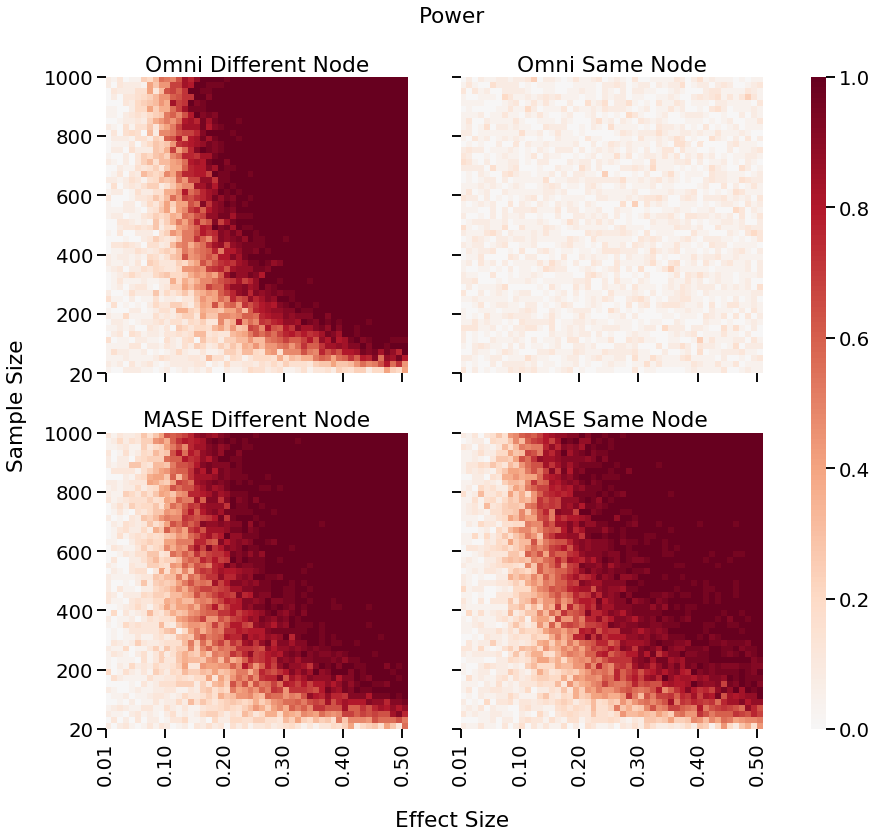

<IPython.core.display.Javascript object>

In [22]:
# Make figure with correct subplots
sns.set_context("talk", font_scale=1.2)
fig, ax = plt.subplots(
    2,
    3,
    gridspec_kw={"width_ratios": [1, 1, 0.05]},
    figsize=(13, 12),
    sharex=True,
    sharey=True,
)
gs = ax[-1, -1].get_gridspec()
for ax_ in ax[:, -1]:
    ax_.remove()

ax_leg = fig.add_subplot(gs[:, -1])

# Plotting
df_cols = [
    ["omni_power_node=1", "omni_power_node=20"],
    ["mase_power_node=1", "mase_power_node=20"],
]

titles = [
    ["Omni Different Node", "Omni Same Node"],
    ["MASE Different Node", "MASE Same Node"],
]

fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[::10]
deltas[0] += 0.01
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

for i, row in enumerate(df_cols):
    for j, df_col in enumerate(row):
        sns.heatmap(
            np.flipud(res_df[df_col].values.reshape(spacing, -1)),
            ax=ax[i, j],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax_leg,
            vmin=0,
            vmax=1,
        )
        ax[i, j].set_xticks(np.arange(0, ax[0, 0].get_xlim()[1] + 1, 10))
        ax[i, j].set_yticks(np.arange(0, ax[0, 0].get_ylim()[0] + 1, 10)[::-1])
        # if i != 0:
        #    ax[i, j].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i, j].set_title(titles[i][j])

fig.text(0.5, 0.95, "Power", va="center", ha="center")
fig.text(0.025, 0.5, "Sample Size", va="center", rotation="vertical")
fig.text(0.5, 0.02, "Effect Size", va="center", ha="center")

In [23]:
fig.savefig("./figures/20200216_embeddings_node_test.png", dpi=300, bbox_inches="tight")

<IPython.core.display.Javascript object>